# 1. Imports

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.decomposition import PCA
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import joblib
import os

# 2. Data Loading

In [2]:
# Data Loading
files = [
    '/kaggle/input/friday.csv',
    '/kaggle/input/friday_plus.csv',
    '/kaggle/input/monday.csv',
    '/kaggle/input/monday_plus.csv',
    '/kaggle/input/thursday.csv',
    '/kaggle/input/thursday_plus.csv',
    '/kaggle/input/tuesday.csv',
    '/kaggle/input/tuesday_plus.csv',
    '/kaggle/input/wednesday.csv',
    '/kaggle/input/wednesday_plus.csv'
]

dfs = []
for f in files:
    if os.path.exists(f):
        df = pd.read_csv(f, low_memory=False).sample(frac=0.1, random_state=42)
        dfs.append(df)
data = pd.concat(dfs, ignore_index=True)


# 3. Exploratory Data Analyis 

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Seaborn style for all plots
sns.set(style="whitegrid")

# Preview data
display(data.head())
print("Columns:", list(data.columns))
print("Label distribution:\n", data['Label'].value_counts())


/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pan

,Src IP dec,Src Port,Dst IP dec,Dst Port,Protocol,Timestamp,Flow Duration,Total Fwd Packet,Total Bwd packets,Total Length of Fwd Packet,...,Local_5,Local_6,Local_7,Local_8,Local_9,Local_10,Local_11,Local_12,Local_13,Local_14
0,3232238089,6246,1746170386,80,6,01:03.1,46577648,12,14,720,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,3232238095,55682,520962311,443,6,14:59.6,6063403,7,5,123,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3232238095,51303,2560833538,443,6,56:41.8,2302745,10,10,993,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3232238096,50010,2899905070,80,6,55:51.5,115775673,17,15,435,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,3232238096,43998,910673203,443,6,14:20.0,5319075,11,7,358,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Columns: ['Src IP dec', 'Src Port', 'Dst IP dec', 'Dst Port', 'Protocol', 'Timestamp', 'Flow Duration', 'Total Fwd Packet', 'Total Bwd packets', 'Total Length of Fwd Packet', 'Total Length of Bwd Packet', 'Fwd Packet Length Max', 'Fwd Packet Length Min', 'Fwd Packet Length Mean', 'Fwd Packet Length Std', 'Bwd Packet Length Max', 'Bwd Packet Length Min', 'Bwd Packet Length Mean', 'Bwd Packet Length Std', 'Flow Bytes/s', 'Flow Packets/s', 'Flow IAT Mean', 'Flow IAT Std', 'Flow IAT Max', 'Flow IAT Min', 'Fwd IAT Total', 'Fwd IAT Mean', 'Fwd IAT Std', 'Fwd IAT Max', 'Fwd IAT Min', 'Bwd IAT Total', 'Bwd IAT Mean', 'Bwd IAT Std', 'Bwd IAT Max', 'Bwd IAT Min', 'Fwd PSH Flags', 'Bwd PSH Flags', 'Fwd URG Flags', 'Bwd URG Flags', 'Fwd RST Flags', 'Bwd RST Flags', 'Fwd Header Length', 'Bwd Header Length', 'Fwd Packets/s', 'Bwd Packets/s', 'Packet Length Min', 'Packet Length Max', 'Packet Length Mean', 'Packet Length Std', 'Packet Length Variance', 'FIN Flag Count', 'SYN Flag Count', 'RST Flag Cou

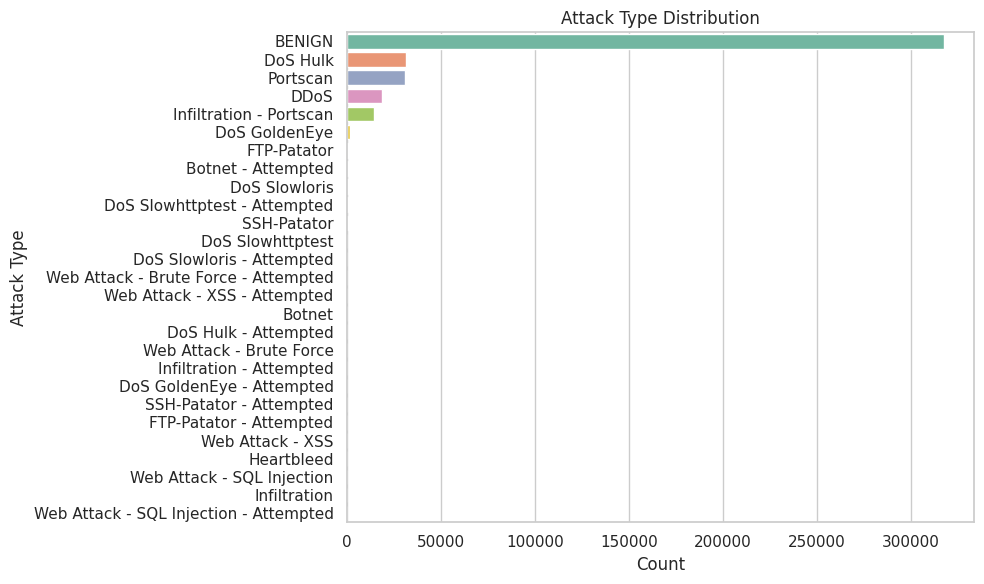

In [4]:
plt.figure(figsize=(10, 6))
order = data['Label'].value_counts().index
sns.barplot(x=data['Label'].value_counts()[order], y=order, palette="Set2")
plt.title('Attack Type Distribution')
plt.xlabel('Count')
plt.ylabel('Attack Type')
plt.tight_layout()
plt.show()


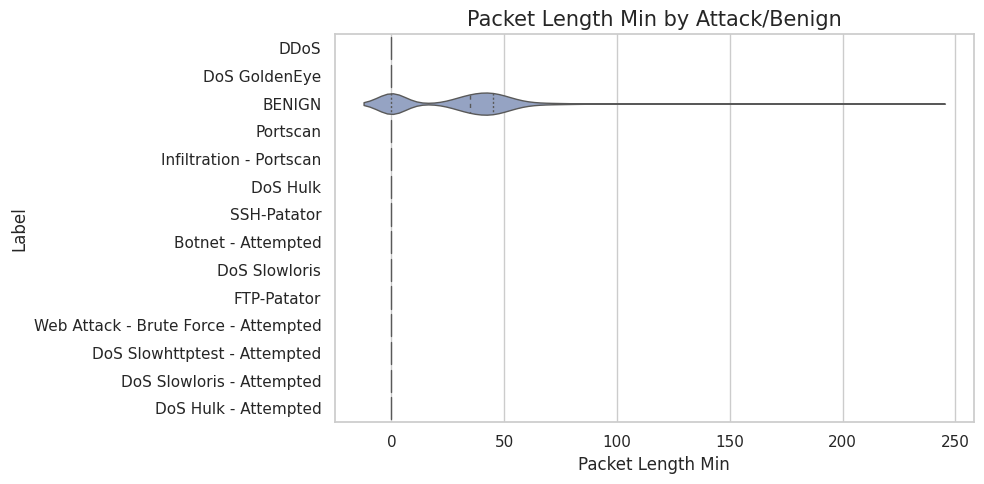

In [5]:
# Pick the first available size feature to avoid clutter
size_feats = ['Packet Length Min', 'Packet Length Mean', 'Packet Length Max']
chosen_size_feat = next((f for f in size_feats if f in data.columns), None)

if chosen_size_feat:
    plt.figure(figsize=(10, 5))
    sns.violinplot(y='Label', x=chosen_size_feat, data=data.sample(min(1000, len(data))), 
                   orient='h', inner='quartile', linewidth=1, palette="Set2")
    plt.title(f'{chosen_size_feat} by Attack/Benign', fontsize=15)
    plt.xlabel(chosen_size_feat)
    plt.ylabel('Label')
    plt.tight_layout()
    plt.show()
else:
    print("No packet length feature found.")


/tmp/ipykernel_36/1734298582.py:3: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  sample['Timestamp'] = pd.to_datetime(sample['Timestamp'], errors='coerce')


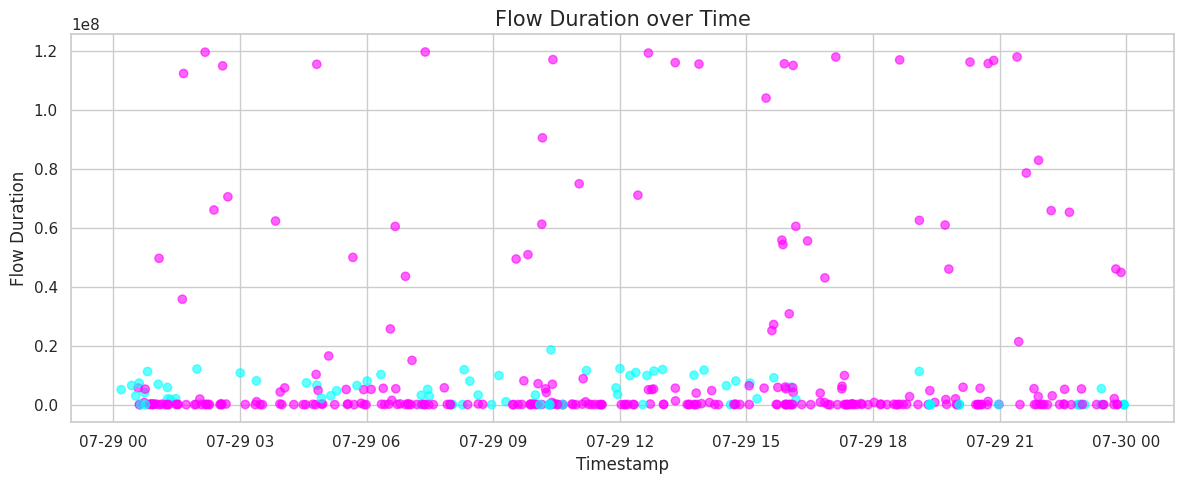

In [6]:
if 'Timestamp' in data.columns and 'Flow Duration' in data.columns:
    sample = data.sample(min(1000, len(data))).copy()
    sample['Timestamp'] = pd.to_datetime(sample['Timestamp'], errors='coerce')
    plt.figure(figsize=(12, 5))
    scatter = plt.scatter(sample['Timestamp'], sample['Flow Duration'], 
                          alpha=0.6, c=(sample['Label'] == 'BENIGN'), cmap='cool')
    plt.xlabel('Timestamp')
    plt.ylabel('Flow Duration')
    plt.title('Flow Duration over Time', fontsize=15)
    plt.tight_layout()
    plt.show()
else:
    print("Required columns for flow duration scatter not found.")


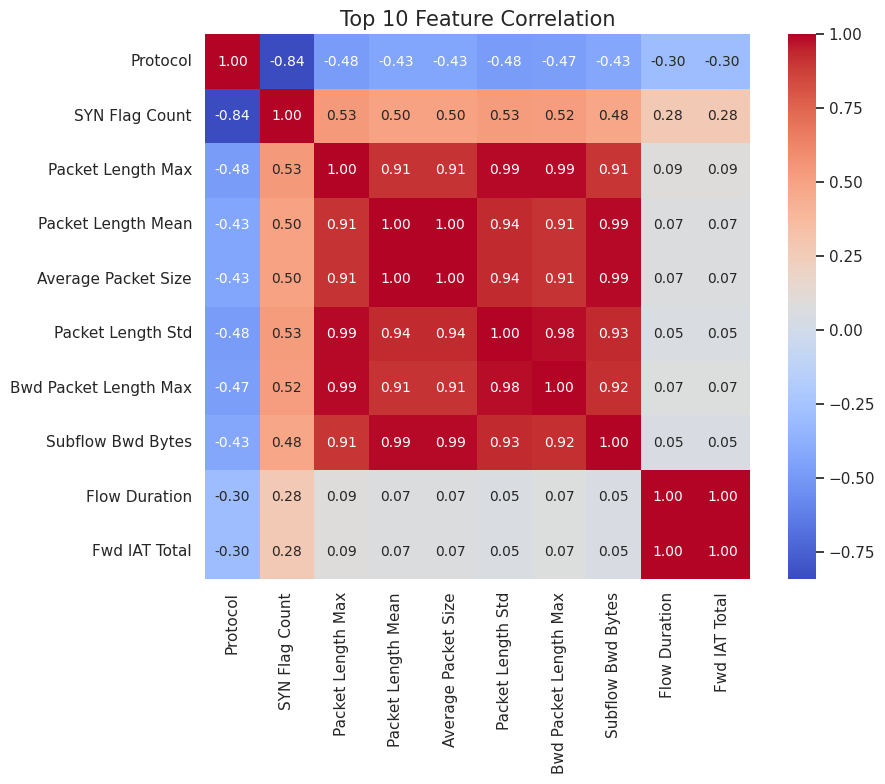

In [7]:
numeric_cols = data.select_dtypes(include=[np.number]).columns
if len(numeric_cols) > 0:
    corr = data[numeric_cols].corr()
    top10 = corr.abs().sum().sort_values(ascending=False)[:10].index
    plt.figure(figsize=(10, 8))
    sns.heatmap(data[top10].corr(), annot=True, cmap="coolwarm", fmt=".2f", square=True, annot_kws={'fontsize': 10})
    plt.title('Top 10 Feature Correlation', fontsize=15)
    plt.tight_layout()
    plt.show()
else:
    print("No numeric columns found for correlation heatmap.")


/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.11/dist-packages/seaborn/categorical.py:3544: UserWarning: 93.9% of the points cannot be placed; you may want to decrease the size of the mar

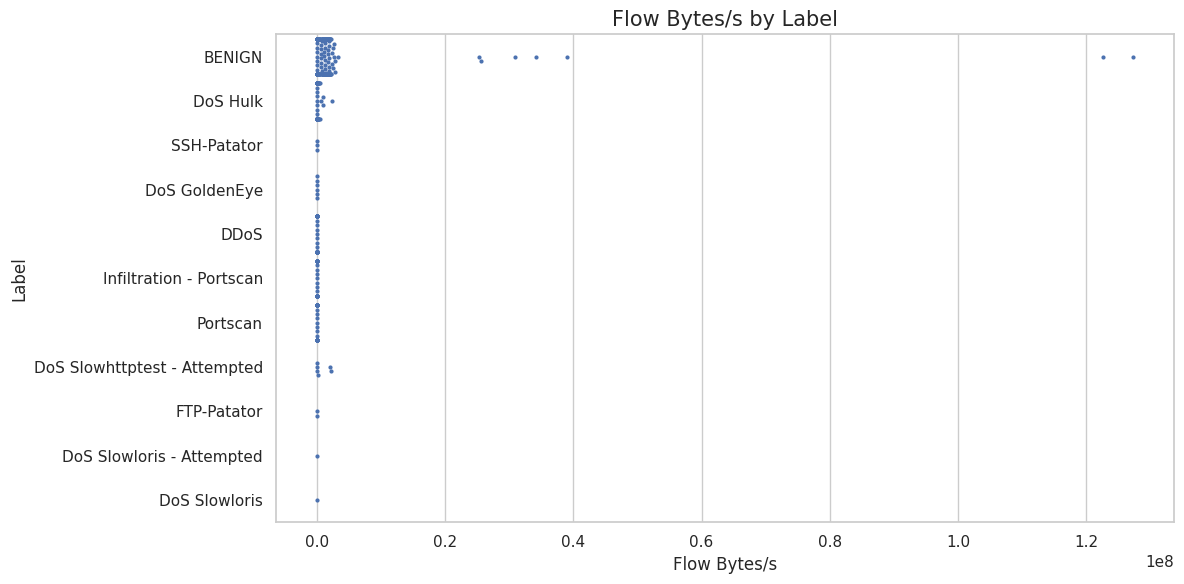

In [8]:
if 'Flow Bytes/s' in data.columns:
    plt.figure(figsize=(12, 6))
    sns.swarmplot(y='Label', x='Flow Bytes/s', data=data.sample(min(1000, len(data))), size=3)
    plt.title('Flow Bytes/s by Label', fontsize=15)
    plt.xlabel('Flow Bytes/s')
    plt.ylabel('Label')
    plt.tight_layout()
    plt.show()
else:
    print("No 'Flow Bytes/s' column found.")


/tmp/ipykernel_36/1830717624.py:7: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(y='Label', x='Total Fwd Packet', data=rare_data,


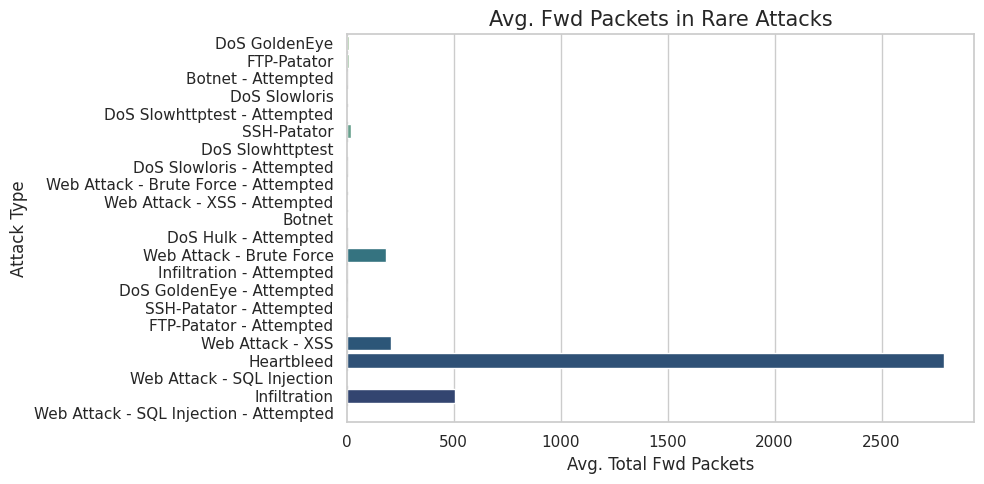

In [9]:
attack_counts = data['Label'].value_counts()
rare_attacks = attack_counts[attack_counts < attack_counts.max() * 0.01].index
if 'Total Fwd Packet' in data.columns and len(rare_attacks) > 0:
    rare_data = data[data['Label'].isin(rare_attacks)]
    if len(rare_data) > 0:
        plt.figure(figsize=(10, 5))
        sns.barplot(y='Label', x='Total Fwd Packet', data=rare_data, 
                    estimator=np.mean, ci=None, order=rare_attacks, palette="crest")
        plt.title('Avg. Fwd Packets in Rare Attacks', fontsize=15)
        plt.xlabel('Avg. Total Fwd Packets')
        plt.ylabel('Attack Type')
        plt.tight_layout()
        plt.show()
    else:
        print("No data for rare attacks.")
else:
    print("No rare attack types or 'Total Fwd Packet' column found.")


# 4. Preprocessing

In [3]:
data.replace([np.inf, -np.inf], np.nan, inplace=True)
data.fillna(0, inplace=True)

if 'Label' in data.columns:
    le = LabelEncoder()
    data['Label'] = le.fit_transform(data['Label'])
    joblib.dump(le, 'label_encoder.pkl')


# 5. Data Balancing

In [8]:
# Select your features (replace with your actual 10-feature list if needed)
features = [
    'Flow Duration', 'Flow Bytes/s', 'Flow Packets/s', 'Fwd IAT Mean',
    'Fwd IAT Max', 'Bwd IAT Mean', 'Packet Length Mean', 'PSH Flag Count',
    'ACK Flag Count', 'Average Packet Size'
]

X = data[features]      # 10 features for training
y = data['Label']       # Already label-encoded above


In [9]:
from sklearn.utils import resample

# Combine features and target
data_bal = pd.concat([X, y], axis=1)
max_count = data_bal['Label'].value_counts().max()
classes = data_bal['Label'].unique()

# Oversample each class to the same max_count
data_list = []
for c in classes:
    class_data = data_bal[data_bal['Label'] == c]
    if len(class_data) < max_count:
        class_data_upsampled = resample(
            class_data,
            replace=True,
            n_samples=max_count,
            random_state=42
        )
        data_list.append(class_data_upsampled)
    else:
        data_list.append(class_data)

data_balanced = pd.concat(data_list)
data_balanced = data_balanced.sample(frac=1, random_state=42)  # Shuffle

# Split again into features/labels
X_balanced = data_balanced[features]
y_balanced = data_balanced['Label']


# 6. Train-Test Split

In [10]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X_balanced, 
    y_balanced, 
    test_size=0.2, 
    random_state=42,
    stratify=y_balanced    
)


# 7. Scaling And PCA

In [11]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import joblib

# --- 1. Scaling ---
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
joblib.dump(scaler, 'scaler.pkl')  # Save for future inference

# --- 2. PCA (you can set n_components < 10 if you want even lower-dimensional data) ---
pca = PCA(n_components=10, random_state=42)
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)
joblib.dump(pca, 'pca.pkl')        # Save for future inference

# --- 3. Check shapes ---
print(f"X_train_scaled shape: {X_train_scaled.shape}")
print(f"X_train_pca shape: {X_train_pca.shape}")
print(f"X_test_scaled shape: {X_test_scaled.shape}")
print(f"X_test_pca shape: {X_test_pca.shape}")


X_train_scaled shape: (6858043, 10)
X_train_pca shape: (6858043, 10)
X_test_scaled shape: (1714511, 10)
X_test_pca shape: (1714511, 10)


# 8. Model Training

In [13]:
import numpy as np

sample_size = 100_000  # Or less if you want it even faster

# Convert y_train to numpy array first
y_train_array = np.array(y_train)

# Concatenate for easy random sampling
Xy_train = np.concatenate([X_train_pca, y_train_array.reshape(-1, 1)], axis=1)

np.random.seed(42)
indices = np.random.choice(Xy_train.shape[0], size=sample_size, replace=False)
Xy_train_small = Xy_train[indices]

# Split back into X and y
X_train_small = Xy_train_small[:, :-1]
y_train_small = Xy_train_small[:, -1].astype(int)


In [14]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
import joblib

# Use fewer estimators for speed (you can increase later if needed)
rf = RandomForestClassifier(
    n_estimators=50,       
    max_depth=12,         
    random_state=42,
    n_jobs=-1
)
rf.fit(X_train_small, y_train_small)
joblib.dump(rf, 'rf_model.pkl')

# Evaluate on the full test set
y_pred_rf = rf.predict(X_test_pca)
print("Random Forest Evaluation (Subset-trained):")
print(f"Accuracy:  {accuracy_score(y_test, y_pred_rf):.4f}")
print(f"F1 Score:  {f1_score(y_test, y_pred_rf, average='weighted'):.4f}")
print(f"Precision: {precision_score(y_test, y_pred_rf, average='weighted'):.4f}")
print(f"Recall:    {recall_score(y_test, y_pred_rf, average='weighted'):.4f}")


Random Forest Evaluation (Subset-trained):
Accuracy:  0.9673
F1 Score:  0.9668
Precision: 0.9697
Recall:    0.9673


# 9. LSTM Model Training

In [17]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

# ----- PARAMETERS -----
sample_size = 100_000    # Reduce for even faster runs (e.g., 25_000)
batch_size = 256
test_batch_size = 2048   # For batched evaluation
epochs = 10
hidden_size = 128
num_layers = 2

# ----- 1. Subsample your balanced PCA'd train set -----
y_train_array = np.array(y_train)
Xy_train = np.concatenate([X_train_pca, y_train_array.reshape(-1, 1)], axis=1)
np.random.seed(42)
indices = np.random.choice(Xy_train.shape[0], size=sample_size, replace=False)
Xy_train_small = Xy_train[indices]
X_train_small = Xy_train_small[:, :-1]
y_train_small = Xy_train_small[:, -1].astype(int)

# ----- 2. Prepare LSTM inputs -----
X_train_lstm = X_train_small.reshape((X_train_small.shape[0], 1, 10))
X_test_lstm = X_test_pca.reshape((X_test_pca.shape[0], 1, 10))

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
X_train_tensor = torch.tensor(X_train_lstm, dtype=torch.float32).to(device)
y_train_tensor = torch.tensor(y_train_small, dtype=torch.long).to(device)
X_test_tensor = torch.tensor(X_test_lstm, dtype=torch.float32).to(device)
y_test_tensor = torch.tensor(np.array(y_test), dtype=torch.long).to(device)

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# ----- 3. Define the LSTM model -----
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, num_classes)
    def forward(self, x):
        out, _ = self.lstm(x)
        out = self.fc(out[:, -1, :])
        return out

num_classes = len(np.unique(y_train))
model = LSTMModel(input_size=10, hidden_size=hidden_size, num_layers=num_layers, num_classes=num_classes).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# ----- 4. Train the LSTM -----
model.train()
for epoch in range(epochs):
    running_loss = 0.0
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    avg_loss = running_loss / len(train_loader)
    print(f"Epoch {epoch+1}/{epochs}, Loss: {avg_loss:.4f}")

# ----- 5. Evaluate on the full test set in batches -----
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
test_loader = DataLoader(test_dataset, batch_size=test_batch_size, shuffle=False)

model.eval()
correct = 0
total = 0
all_preds = []
all_targets = []
with torch.no_grad():
    for inputs, labels in test_loader:
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)
        all_preds.append(predicted.cpu().numpy())
        all_targets.append(labels.cpu().numpy())
    acc = correct / total
    print(f"LSTM Test Accuracy: {acc:.4f}")

# Optionally, you can flatten all_preds and all_targets for further metrics
# import numpy as np
# y_true = np.concatenate(all_targets)
# y_pred = np.concatenate(all_preds)

# ----- 6. Save model -----
torch.save(model.state_dict(), '/kaggle/working/lstm_model.pth')
torch.save(model, '/kaggle/working/lstm.pkl')


Epoch 1/10, Loss: 1.6896
Epoch 2/10, Loss: 0.6903
Epoch 3/10, Loss: 0.5220
Epoch 4/10, Loss: 0.4520
Epoch 5/10, Loss: 0.4136
Epoch 6/10, Loss: 0.3868
Epoch 7/10, Loss: 0.3614
Epoch 8/10, Loss: 0.3406
Epoch 9/10, Loss: 0.3220
Epoch 10/10, Loss: 0.3078
LSTM Test Accuracy: 0.8645


# 10. Model Evaluation


====== LSTM Model Evaluation ======
LSTM Classification Report:
              precision    recall  f1-score   support

           0     0.8927    0.8455    0.8685     63500
           1     0.9891    0.9842    0.9867     63500
           2     0.7162    0.4403    0.5453     63500
           3     0.9579    0.9517    0.9548     63501
           4     0.9844    0.9953    0.9898     63500
           5     0.4827    0.8329    0.6112     63500
           6     0.9392    0.9540    0.9465     63501
           7     0.9951    0.6180    0.7625     63501
           8     0.9860    0.9894    0.9877     63500
           9     0.9855    0.9943    0.9899     63500
          10     0.9895    0.9806    0.9851     63501
          11     0.9877    0.9334    0.9598     63500
          12     0.9979    0.9950    0.9965     63500
          13     0.9839    1.0000    0.9919     63500
          14     1.0000    1.0000    1.0000     63501
          15     0.9999    1.0000    1.0000     63500
          16    

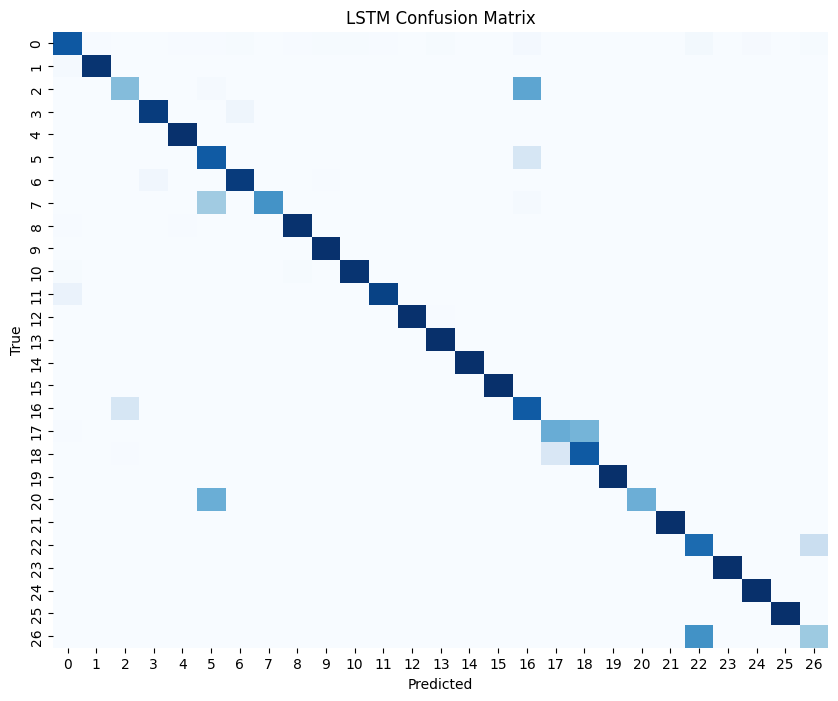


====== Random Forest Model Evaluation ======
Random Forest Classification Report:
              precision    recall  f1-score   support

           0     0.9751    0.9357    0.9550     63500
           1     0.9984    1.0000    0.9992     63500
           2     0.9953    0.9444    0.9692     63500
           3     0.9813    0.9711    0.9762     63501
           4     0.9790    0.9934    0.9861     63500
           5     0.9999    1.0000    0.9999     63500
           6     0.9659    0.9848    0.9752     63501
           7     0.9997    1.0000    0.9998     63501
           8     0.9911    1.0000    0.9955     63500
           9     0.9936    1.0000    0.9968     63500
          10     0.9947    0.9864    0.9906     63501
          11     0.9998    1.0000    0.9999     63500
          12     0.9995    1.0000    0.9997     63500
          13     0.9993    1.0000    0.9997     63500
          14     0.9999    1.0000    0.9999     63501
          15     1.0000    1.0000    1.0000     6350

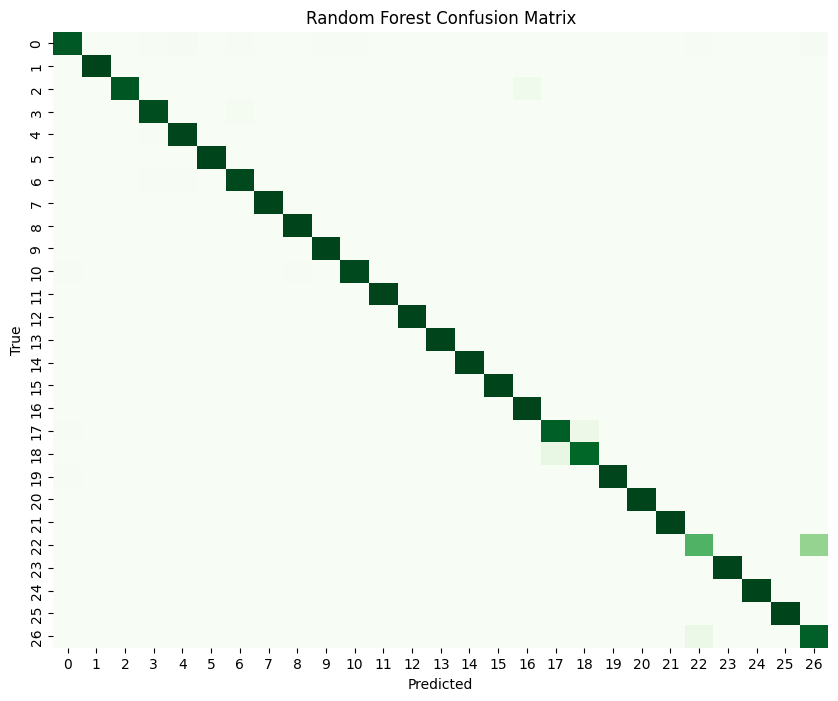

In [18]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score, precision_score, recall_score
import matplotlib.pyplot as plt
import seaborn as sns

# --------- LSTM Evaluation ---------
print("\n====== LSTM Model Evaluation ======")
y_true_lstm = np.concatenate(all_targets)
y_pred_lstm = np.concatenate(all_preds)

print("LSTM Classification Report:")
print(classification_report(y_true_lstm, y_pred_lstm, digits=4))

print(f"LSTM Accuracy:  {accuracy_score(y_true_lstm, y_pred_lstm):.4f}")
print(f"LSTM F1 Score:  {f1_score(y_true_lstm, y_pred_lstm, average='weighted'):.4f}")
print(f"LSTM Precision: {precision_score(y_true_lstm, y_pred_lstm, average='weighted'):.4f}")
print(f"LSTM Recall:    {recall_score(y_true_lstm, y_pred_lstm, average='weighted'):.4f}")

cm_lstm = confusion_matrix(y_true_lstm, y_pred_lstm)
plt.figure(figsize=(10,8))
sns.heatmap(cm_lstm, cmap="Blues", cbar=False)
plt.title("LSTM Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

# --------- Random Forest Evaluation ---------
print("\n====== Random Forest Model Evaluation ======")
# Predict on test set (already done, but re-run to be sure)
y_pred_rf = rf.predict(X_test_pca)
y_true_rf = np.array(y_test)

print("Random Forest Classification Report:")
print(classification_report(y_true_rf, y_pred_rf, digits=4))

print(f"Random Forest Accuracy:  {accuracy_score(y_true_rf, y_pred_rf):.4f}")
print(f"Random Forest F1 Score:  {f1_score(y_true_rf, y_pred_rf, average='weighted'):.4f}")
print(f"Random Forest Precision: {precision_score(y_true_rf, y_pred_rf, average='weighted'):.4f}")
print(f"Random Forest Recall:    {recall_score(y_true_rf, y_pred_rf, average='weighted'):.4f}")

cm_rf = confusion_matrix(y_true_rf, y_pred_rf)
plt.figure(figsize=(10,8))
sns.heatmap(cm_rf, cmap="Greens", cbar=False)
plt.title("Random Forest Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()


# 11. Predictions using both models

In [27]:
import torch
import joblib
import numpy as np
import pandas as pd

# 1. Load transformers and RF as before
scaler = joblib.load('/kaggle/working/scaler.pkl')
pca = joblib.load('/kaggle/working/pca.pkl')
le = joblib.load('/kaggle/working/label_encoder.pkl')
rf = joblib.load('/kaggle/working/rf_model.pkl')

# 2. Define the LSTM model class (must match how you trained)
class LSTMModel(torch.nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes):
        super(LSTMModel, self).__init__()
        self.lstm = torch.nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = torch.nn.Linear(hidden_size, num_classes)
    def forward(self, x):
        out, _ = self.lstm(x)
        out = self.fc(out[:, -1, :])
        return out

# 3. Recreate and load weights
input_size = 10
hidden_size = 128
num_layers = 2
num_classes = len(le.classes_)  # safer, matches your label encoder
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

lstm = LSTMModel(input_size, hidden_size, num_layers, num_classes).to(device)
lstm.load_state_dict(torch.load('/kaggle/working/lstm_model.pth', map_location=device))
lstm.eval()

# 4. Create random sample and preprocess (same as before)
features = [
    'Flow Duration', 'Flow Bytes/s', 'Flow Packets/s', 'Fwd IAT Mean',
    'Fwd IAT Max', 'Bwd IAT Mean', 'Packet Length Mean', 'PSH Flag Count',
    'ACK Flag Count', 'Average Packet Size'
]
sample_input = np.random.rand(1, 10) * 1000
sample_df = pd.DataFrame(sample_input, columns=features)
sample_scaled = scaler.transform(sample_df)
sample_pca = pca.transform(sample_scaled)

# 5. Random Forest prediction
rf_pred = rf.predict(sample_pca)
rf_label = le.inverse_transform([rf_pred[0]])[0]
print(f"Random Forest Prediction: {rf_pred[0]} (Label: {rf_label})")

# 6. LSTM prediction
sample_lstm_tensor = torch.tensor(sample_pca.reshape(1, 1, 10), dtype=torch.float32).to(device)
with torch.no_grad():
    lstm_out = lstm(sample_lstm_tensor)
    _, lstm_pred = torch.max(lstm_out, 1)
lstm_label = le.inverse_transform([lstm_pred.item()])[0]
print(f"LSTM Prediction: {lstm_pred.item()} (Label: {lstm_label})")


Random Forest Prediction: 15 (Label: Infiltration)
LSTM Prediction: 13 (Label: FTP-Patator - Attempted)


# 12. Model Explainability and Analysis

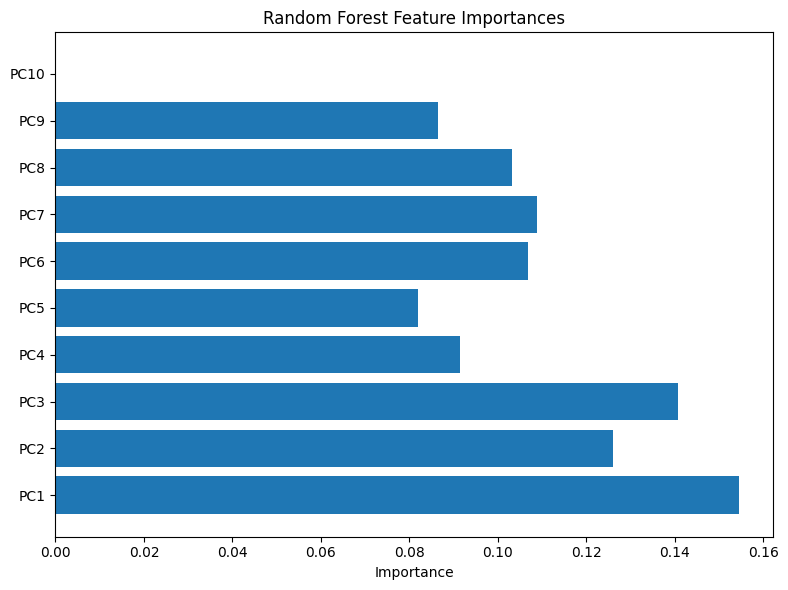

In [29]:
import numpy as np
import matplotlib.pyplot as plt

importances = rf.feature_importances_
pca_feature_names = [f'PC{i+1}' for i in range(X_test_pca.shape[1])]

plt.figure(figsize=(8,6))
plt.barh(pca_feature_names, importances)
plt.xlabel("Importance")
plt.title("Random Forest Feature Importances")
plt.tight_layout()
plt.show()


In [32]:
# 1. Install LIME if not present (should work in Kaggle)
!pip install lime --quiet

# 2. Import and set up LIME
import lime
import lime.lime_tabular
import numpy as np

# 3. Prepare explainer for PCA features
explainer = lime.lime_tabular.LimeTabularExplainer(
    training_data=X_train_pca,
    feature_names=[f'PC{i+1}' for i in range(X_train_pca.shape[1])],
    class_names=[str(c) for c in le.classes_],  # or just ["class1", ...] if you want
    mode='classification'
)

# 4. Select a test sample (row index, e.g. 0)
i = 0
sample = X_test_pca[i]

# 5. Explain prediction
exp = explainer.explain_instance(
    data_row=sample,
    predict_fn=rf.predict_proba,   # works for any sklearn classifier
    num_features=10
)

# 6. Show explanation in notebook
exp.show_in_notebook(show_table=True, show_all=False)

# Or print as text (if running in script)
print(exp.as_list())


[('PC1 <= -1.27', 0.014359267289349692), ('-0.05 < PC9 <= -0.00', -0.009819345650200366), ('0.12 < PC5 <= 0.16', 0.005556790051610662), ('0.08 < PC4 <= 0.15', 0.0038547644826816413), ('-0.19 < PC3 <= -0.15', 0.0038311220979884352), ('-0.03 < PC7 <= 0.02', -0.0025377437032492547), ('PC6 > 0.29', 0.0010067387211517068), ('-0.00 < PC2 <= 0.14', 0.0008413148578084407), ('-0.03 < PC8 <= -0.02', -0.0005643595953575263), ('PC10 > 0.00', -6.58143676749703e-05)]
